# The mechanics of learning

This chapter covers
* Understanding how algorithms can learn from data
* Reframing learning as parameter estimation, using differentiation and gradient descent
* Walking through a simple learning algorithm
* How PyTorch supports learning with autograd

# 5.1 A timeless lesson in modeling

Building models that allow us to explain input/output relationships dates back centu-
ries at least. When Johannes Kepler, a German mathematical astronomer (1571–1630),
figured out his three laws of planetary motion in the early 1600s, he based them on
data collected by his mentor Tycho Brahe during naked-eye observations (yep, seen
with the naked eye and written on a piece of paper). Not having Newton’s law of grav-
itation at his disposal (actually, Newton used Kepler’s work to figure things out),
Kepler extrapolated the simplest possible geometric model that could fit the data.
And, by the way, it took him six years of staring at data that didn’t make sense to him,
together with incremental realizations, to finally formulate these laws.1 We can see this
process in figure 5.1.

![Figure_5.1.png](Images_ch5/Figure_5.1.png)

Kepler’s first law reads: “The orbit of every planet is an ellipse with the Sun at one of
the two foci.” He didn’t know what caused orbits to be ellipses, but given a set of obser-
vations for a planet (or a moon of a large planet, like Jupiter), he could estimate the
shape (the eccentricity) and size (the semi-latus rectum) of the ellipse. With those two
parameters computed from the data, he could tell where the planet might be during its journey in the sky. Once he figured out the second law—“A line joining a planet
and the Sun sweeps out equal areas during equal intervals of time”—he could also tell
when a planet would be at a particular point in space, given observations in time.2
So, how did Kepler estimate the eccentricity and size of the ellipse without comput-
ers, pocket calculators, or even calculus, none of which had been invented yet? We
can learn how from Kepler’s own recollection, in his book New Astronomy, or from how
J. V. Field put it in his series of articles, “The origins of proof,” (http://mng.bz/9007):

> Essentially, Kepler had to try different shapes, using a certain number of observations to find
the curve, then use the curve to find some more positions, for times when he had observations
available, and then check whether these calculated positions agreed with the observed ones.
—J. V. Field

So let’s sum things up. Over six years, Kepler

* Got lots of good data from his friend Brahe (not without some struggle)
* Tried to visualize the heck out of it, because he felt there was something fishygoing on
* Chose the simplest possible model that had a chance to fit the data (an ellipse)
* Split the data so that he could work on part of it and keep an independent set for validation
* Started with a tentative eccentricity and size for the ellipse and iterated until the model fit the observations
* Validated his model on the independent observations
* Looked back in disbelief

In this book, we’re interested in models that are not engineered for solving a spe-
cific narrow task, but that can be automatically adapted to specialize themselves for
any one of many similar tasks using input and output pairs—in other words, general
models trained on data relevant to the specific task at hand. In particular, PyTorch is
designed to make it easy to create models for which the derivatives of the fitting error,
with respect to the parameters, can be expressed analytically. No worries if this last
sentence didn’t make any sense at all; coming next, we have a full section that hope-
fully clears it up for you.

# 5.2 Learning is just parameter estimation

Figure 5.2 shows the high-level overview of what we’ll implement by the end of the
chapter. Given input data and the corresponding desired outputs (ground truth), as
well as initial values for the weights, the model is fed input data (forward pass), and a
measure of the error is evaluated by comparing the resulting outputs to the ground
truth. In order to optimize the parameter of the model—its weights—the change in
the error following a unit change in weights (that is, the gradient of the error with
respect to the parameters) is computed using the chain rule for the derivative of a
composite function (backward pass). The value of the weights is then updated in the
direction that leads to a decrease in the error. The procedure is repeated until the
error, evaluated on unseen data, falls below an acceptable level. If what we just said
sounds obscure, we’ve got a whole chapter to clear things up. By the time we’re done,
all the pieces will fall into place, and this paragraph will make perfect sense.

![Figure_5.2.png](Images_ch5/Figure_5.2.png)

We just got back from a trip to some obscure location, and we brought back a fancy,
wall-mounted analog thermometer. It looks great, and it’s a perfect fit for our living
room. Its only flaw is that it doesn’t show units. Not to worry, we’ve got a plan: we’ll
build a dataset of readings and corresponding temperature values in our favorite
units, choose a model, adjust its weights iteratively until a measure of the error is low
enough, and finally be able to interpret the new readings in units we understand.

In [45]:
import torch
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

Here, the t_c values are temperatures in Celsius, and the t_u values are our unknown
units. We can expect noise in both measurements, coming from the devices them-
selves and from our approximate readings. For convenience, we’ve already put the
data into tensors; we’ll use it in a minute.

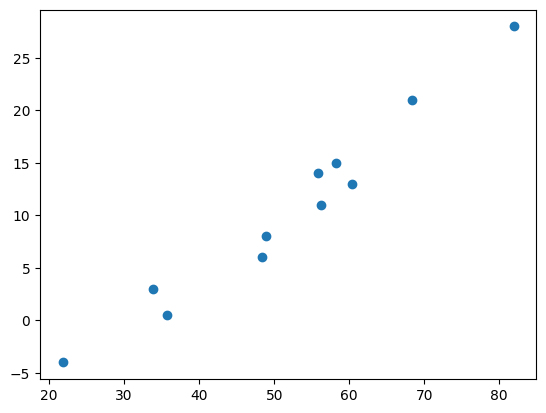

In [46]:
import matplotlib.pyplot as plt
plt.scatter(t_u,t_c)
plt.show()

In the absence of further knowledge, we assume the simplest possible model for con-
verting between the two sets of measurements, just like Kepler might have done. The
two may be linearly related—that is, multiplying t_u by a factor and adding a constant,
we may get the temperature in Celsius (up to an error that we omit):

t_c = w * t_u + b

Let’s flesh it out again: we have a model with some unknown parameters, and we
need to estimate those parameters so that the error between predicted outputs and
measured values is as low as possible. We notice that we still need to exactly define a
measure of the error. Such a measure, which we refer to as the loss function, should be
high if the error is high and should ideally be as low as possible for a perfect match.
Our optimization process should therefore aim at finding w and b so that the loss
function is at a minimum.

# 5.5 Less loss is what we want

A loss function (or cost function) is a function that computes a single numerical value
that the learning process will attempt to minimize. The calculation of loss typically
involves taking the difference between the desired outputs for some training samples
and the outputs actually produced by the model when fed those samples. In our case,
that would be the difference between the predicted temperatures t_p output by our
model and the actual measurements: t_p – t_c.

We need to make sure the loss function makes the loss positive both when t_p is
greater than and when it is less than the true t_c, since the goal is for t_p to match t_c.
We have a few choices, the most straightforward being |t_p – t_c| and (t_p – t_c)^2.
Based on the mathematical expression we choose, we can emphasize or discount certain
errors. Conceptually, a loss function is a way of prioritizing which errors to fix from our
training samples, so that our parameter updates result in adjustments to the outputs for
the highly weighted samples instead of changes to some other samples’ output that had
a smaller loss.

We’ve figured out the model and the loss function—we’ve already got a good part of
the high-level picture in figure 5.2 figured out. Now we need to set the learning pro-
cess in motion and feed it actual data. Also, enough with math notation; let’s switch to
PyTorch—after all, we came here for the fun.
We’ve already created our data tensors, so now let’s write out the model as a
Python function:

In [47]:
def model(t_u, w, b):
    return w * t_u + b

We’re expecting t_u, w, and b to be the input tensor, weight parameter, and bias
parameter, respectively. In our model, the parameters will be PyTorch scalars (aka zero-dimensional tensors), and the product operation will use broadcasting to yield
the returned tensors. Anyway, time to define our loss:

In [48]:
#Mean square loss
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

Note that we are building a tensor of differences, taking their square element-wise,
and finally producing a scalar loss function by averaging all of the elements in the
resulting tensor. It is a mean square loss.

In [49]:
w = torch.ones(())
b = torch.zeros(())
t_p = model(t_u, w, b)
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])

In [50]:
loss = loss_fn(t_p, t_c)
loss

tensor(1763.8848)

We implemented the model and the loss in this section. We’ve finally reached the
meat of the example: how do we estimate w and b such that the loss reaches a mini-
mum? We’ll first work things out by hand and then learn how to use PyTorch’s super-
powers to solve the same problem in a more general, off-the-shelf way.

## Broadcasting
 

We mentioned broadcasting in chapter 3, and we promised to look at it more carefully
when we need it. In our example, we have two scalars (zero-dimensional tensors) w
and b, and we multiply them with and add them to vectors (one-dimensional tensors)
of length b.
Usually—and in early versions of PyTorch, too—we can only use element-wise binary
operations such as addition, subtraction, multiplication, and division for arguments
of the same shape. The entries in matching positions in each of the tensors will be
used to calculate the corresponding entry in the result tensor.

<font color='red'>It uses the following rules to match tensor elements:</font>

* For each index dimension, counted from the back, if one of the operands is
size 1 in that dimension, PyTorch will use the single entry along this dimen-
sion with each of the entries in the other tensor along this dimension.
* If both sizes are greater than 1, they must be the same, and natural matching
is used.
* If one of the tensors has more index dimensions than the other, the entirety
of the other tensor will be used for each entry along these dimensions.

This sounds complicated (and it can be error-prone if we don’t pay close attention, which
is why we have named the tensor dimensions as shown in section 3.4), but usually,
we can either write down the tensor dimensions to see what happens or picture what
happens by using space dimensions to show the broadcasting, as in the following figure.
Of course, this would all be theory if we didn’t have some code examples:

In [51]:
x = torch.ones(())
y = torch.ones(3,1)
z = torch.ones(1,3)
a = torch.ones(2, 1, 1)
print(f"shapes: x: {x.shape}, y: {y.shape}")
print(f"z: {z.shape}, a: {a.shape}")
print("x * y:", (x * y).shape)
print("y * z:", (y * z).shape)
print("y * z * a:", (y * z * a).shape)

shapes: x: torch.Size([]), y: torch.Size([3, 1])
z: torch.Size([1, 3]), a: torch.Size([2, 1, 1])
x * y: torch.Size([3, 1])
y * z: torch.Size([3, 3])
y * z * a: torch.Size([2, 3, 3])


# 5.5 Down along the gradient

We’ll optimize the loss function with respect to the parameters using the gradient
descent algorithm. In this section, we’ll build our intuition for how gradient descent
works from first principles, which will help us a lot in the future. As we mentioned,
there are ways to solve our example problem more efficiently, but those approaches
aren’t applicable to most deep learning tasks. Gradient descent is actually a very sim-
ple idea, and it scales up surprisingly well to large neural network models with mil-
lions of parameters.

In [52]:
delta = 0.1
loss_rate_of_change_w = \
(loss_fn(model(t_u, w + delta, b), t_c) -
loss_fn(model(t_u, w - delta, b), t_c)) / (2.0 * delta)

This is saying that in the neighborhood of the current values of w and b, a unit
increase in w leads to some change in the loss. If the change is negative, then we need
to increase w to minimize the loss, whereas if the change is positive, we need to
decrease w. By how much? Applying a change to w that is proportional to the rate of
change of the loss is a good idea, especially when the loss has several parameters: we
apply a change to those that exert a significant change on the loss. It is also wise to
change the parameters slowly in general, because the rate of change could be dramat-
ically different at a distance from the neighborhood of the current w value. Therefore,
we typically should scale the rate of change by a small factor. This scaling factor has
many names; the one we use in machine learning is learning_rate:

In [53]:
learning_rate = 1e-2
w = w - learning_rate * loss_rate_of_change_w

In [54]:
loss_rate_of_change_b = \
(loss_fn(model(t_u, w, b + delta), t_c) -
loss_fn(model(t_u, w, b - delta), t_c)) / (2.0 * delta)
b = b - learning_rate * loss_rate_of_change_b

Computing the rate of change by using repeated evaluations of the model and loss in
order to probe the behavior of the loss function in the neighborhood of w and b
doesn’t scale well to models with many parameters. Also, it is not always clear how
large the neighborhood should be. We chose delta equal to 0.1 in the previous sec-
tion, but it all depends on the shape of the loss as a function of w and b. If the loss
changes too quickly compared to delta, we won’t have a very good idea of in which
direction the loss is decreasing the most.
What if we could make the neighborhood infinitesimally small, as in figure 5.6?
That’s exactly what happens when we analytically take the derivative of the loss with
respect to a parameter. In a model with two or more parameters like the one we’re
dealing with, we compute the individual derivatives of the loss with respect to each
parameter and put them in a vector of derivatives: the gradient.

In [55]:
def dloss_fn(t_p, t_c):
    dsq_diffs = 2 * (t_p - t_c) / t_p.size(0)
    return dsq_diffs

In [56]:
def dmodel_dw(t_u, w, b):
    return t_u

In [57]:
def dmodel_db(t_u, w, b):
    return 1.0

In [58]:
def grad_fn(t_u, t_c, t_p, w, b):
    dloss_dtp = dloss_fn(t_p, t_c)
    dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b)
    dloss_db = dloss_dtp * dmodel_db(t_u, w, b)
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])

It took me some time to understand this formula, but I think I have understood it finally. So, our loss function formula is MSE and it's derivative is 2(tp-tc)/len(tp) and because we want to have our partial derivative of the model be in regards to weigths or biases we think of tp as an inner function, (w*x+b) that is why we use the chain rule calculate our dw and db

![Figure_5.7.png](Images_ch5/Figure_5.7.png)

In [59]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        w, b = params
        #print(w, b)
        t_p = model(t_u, w, b)
        #print(t_p)
        loss = loss_fn(t_p, t_c)
        #print(loss)
        grad = grad_fn(t_u, t_c, t_p, w, b)
        #print(grad)
        params = params - learning_rate * grad
        #print(params)
        print('Epoch %d, Loss %f' % (epoch, float(loss)))
    return params


In [60]:
training_loop(
n_epochs = 100,
learning_rate = 1e-4,
params = torch.tensor([1.0, 0.0]),
t_u = t_u,
t_c = t_c)

Epoch 1, Loss 1763.884766
Epoch 2, Loss 323.090515
Epoch 3, Loss 78.929634
Epoch 4, Loss 37.552845
Epoch 5, Loss 30.540283
Epoch 6, Loss 29.351154
Epoch 7, Loss 29.148884
Epoch 8, Loss 29.113848
Epoch 9, Loss 29.107145
Epoch 10, Loss 29.105247
Epoch 11, Loss 29.104168
Epoch 12, Loss 29.103222
Epoch 13, Loss 29.102295
Epoch 14, Loss 29.101379
Epoch 15, Loss 29.100466
Epoch 16, Loss 29.099548
Epoch 17, Loss 29.098631
Epoch 18, Loss 29.097717
Epoch 19, Loss 29.096796
Epoch 20, Loss 29.095881
Epoch 21, Loss 29.094959
Epoch 22, Loss 29.094049
Epoch 23, Loss 29.093134
Epoch 24, Loss 29.092216
Epoch 25, Loss 29.091301
Epoch 26, Loss 29.090385
Epoch 27, Loss 29.089464
Epoch 28, Loss 29.088551
Epoch 29, Loss 29.087635
Epoch 30, Loss 29.086714
Epoch 31, Loss 29.085804
Epoch 32, Loss 29.084888
Epoch 33, Loss 29.083967
Epoch 34, Loss 29.083057
Epoch 35, Loss 29.082142
Epoch 36, Loss 29.081221
Epoch 37, Loss 29.080309
Epoch 38, Loss 29.079390
Epoch 39, Loss 29.078474
Epoch 40, Loss 29.077562
Epoch 

tensor([ 0.2327, -0.0438])

We can see that the first-epoch gradient for the weight is about 50 times larger than
the gradient for the bias. This means the weight and bias live in differently scaled
spaces. If this is the case, a learning rate that’s large enough to meaningfully update
one will be so large as to be unstable for the other; and a rate that’s appropriate for
the other won’t be large enough to meaningfully change the first. That means we’re
not going to be able to update our parameters unless we change something about our
formulation of the problem. We could have individual learning rates for each parame-
ter, but for models with many parameters, this would be too much to bother with; it’s
babysitting of the kind we don’t like.

There’s a simpler way to keep things in check: changing the inputs so that the gra-
dients aren’t quite so different. We can make sure the range of the input doesn’t get
too far from the range of –1.0 to 1.0, roughly speaking. In our case, we can achieve
something close enough to that by simply multiplying t_u by 0.1:

In [61]:
t_un = t_u*0.1

Here, we denote the normalized version of t_u by appending an n to the variable
name. At this point, we can run the training loop on our normalized input:

In [62]:
training_loop(
n_epochs = 100,
learning_rate = 1e-2,
params = torch.tensor([1.0, 0.0]),
t_u = t_un,
t_c = t_c)

Epoch 1, Loss 80.364342
Epoch 2, Loss 37.574913
Epoch 3, Loss 30.871077
Epoch 4, Loss 29.756193
Epoch 5, Loss 29.507153
Epoch 6, Loss 29.392456
Epoch 7, Loss 29.298828
Epoch 8, Loss 29.208717
Epoch 9, Loss 29.119415
Epoch 10, Loss 29.030489
Epoch 11, Loss 28.941877
Epoch 12, Loss 28.853565
Epoch 13, Loss 28.765553
Epoch 14, Loss 28.677851
Epoch 15, Loss 28.590431
Epoch 16, Loss 28.503319
Epoch 17, Loss 28.416498
Epoch 18, Loss 28.329973
Epoch 19, Loss 28.243742
Epoch 20, Loss 28.157804
Epoch 21, Loss 28.072151
Epoch 22, Loss 27.986797
Epoch 23, Loss 27.901728
Epoch 24, Loss 27.816950
Epoch 25, Loss 27.732464
Epoch 26, Loss 27.648256
Epoch 27, Loss 27.564344
Epoch 28, Loss 27.480707
Epoch 29, Loss 27.397362
Epoch 30, Loss 27.314295
Epoch 31, Loss 27.231512
Epoch 32, Loss 27.149010
Epoch 33, Loss 27.066790
Epoch 34, Loss 26.984844
Epoch 35, Loss 26.903175
Epoch 36, Loss 26.821791
Epoch 37, Loss 26.740679
Epoch 38, Loss 26.659838
Epoch 39, Loss 26.579279
Epoch 40, Loss 26.498987
Epoch 41,

tensor([ 2.7553, -2.5162])

Even though we set our learning rate back to 1e-2, parameters don’t blow up during
iterative updates. Let’s take a look at the gradients: they’re of similar magnitude, so
using a single learning_rate for both parameters works just fine. We could probably
do a better job of normalization than a simple rescaling by a factor of 10, but since
doing so is good enough for our needs, we’re going to stick with that for now.

The normalization here absolutely helps get the network trained, but
you could make an argument that it’s not strictly needed to optimize the
parameters for this particular problem. That’s absolutely true! This problem is
small enough that there are numerous ways to beat the parameters into sub-
mission. However, for larger, more sophisticated problems, normalization is an
easy and effective (if not crucial!) tool to use to improve model convergence.

Let’s run the loop for enough iterations to see the changes in params get small. We’ll
change n_epochs to 5,000:

In [63]:
params = training_loop(
n_epochs = 5000,
learning_rate = 1e-3,
params = torch.tensor([1.0, 0.0]),
t_u = t_un,
t_c = t_c,)

Epoch 1, Loss 80.364342
Epoch 2, Loss 74.413010
Epoch 3, Loss 69.160568
Epoch 4, Loss 64.524818
Epoch 5, Loss 60.433224
Epoch 6, Loss 56.821793
Epoch 7, Loss 53.634056
Epoch 8, Loss 50.820156
Epoch 9, Loss 48.336143
Epoch 10, Loss 46.143223
Epoch 11, Loss 44.207150
Epoch 12, Loss 42.497715
Epoch 13, Loss 40.988270
Epoch 14, Loss 39.655285
Epoch 15, Loss 38.478008
Epoch 16, Loss 37.438126
Epoch 17, Loss 36.519493
Epoch 18, Loss 35.707829
Epoch 19, Loss 34.990566
Epoch 20, Loss 34.356586
Epoch 21, Loss 33.796120
Epoch 22, Loss 33.300499
Epoch 23, Loss 32.862114
Epoch 24, Loss 32.474216
Epoch 25, Loss 32.130878
Epoch 26, Loss 31.826860
Epoch 27, Loss 31.557531
Epoch 28, Loss 31.318819
Epoch 29, Loss 31.107122
Epoch 30, Loss 30.919256
Epoch 31, Loss 30.752424
Epoch 32, Loss 30.604156
Epoch 33, Loss 30.472261
Epoch 34, Loss 30.354820
Epoch 35, Loss 30.250134
Epoch 36, Loss 30.156694
Epoch 37, Loss 30.073187
Epoch 38, Loss 29.998436
Epoch 39, Loss 29.931427
Epoch 40, Loss 29.871235
Epoch 41,

In [64]:
params = training_loop(
n_epochs = 5000,
learning_rate = 1e-4,
params = torch.tensor([1.0, 0.0]),
t_u = t_un,
t_c = t_c,)

Epoch 1, Loss 80.364342
Epoch 2, Loss 79.752480
Epoch 3, Loss 79.148026
Epoch 4, Loss 78.550865
Epoch 5, Loss 77.960899
Epoch 6, Loss 77.378052
Epoch 7, Loss 76.802254
Epoch 8, Loss 76.233406
Epoch 9, Loss 75.671425
Epoch 10, Loss 75.116219
Epoch 11, Loss 74.567734
Epoch 12, Loss 74.025856
Epoch 13, Loss 73.490532
Epoch 14, Loss 72.961662
Epoch 15, Loss 72.439178
Epoch 16, Loss 71.923004
Epoch 17, Loss 71.413055
Epoch 18, Loss 70.909271
Epoch 19, Loss 70.411568
Epoch 20, Loss 69.919861
Epoch 21, Loss 69.434097
Epoch 22, Loss 68.954185
Epoch 23, Loss 68.480080
Epoch 24, Loss 68.011688
Epoch 25, Loss 67.548958
Epoch 26, Loss 67.091805
Epoch 27, Loss 66.640167
Epoch 28, Loss 66.193993
Epoch 29, Loss 65.753181
Epoch 30, Loss 65.317703
Epoch 31, Loss 64.887482
Epoch 32, Loss 64.462448
Epoch 33, Loss 64.042534
Epoch 34, Loss 63.627697
Epoch 35, Loss 63.217857
Epoch 36, Loss 62.812977
Epoch 37, Loss 62.412975
Epoch 38, Loss 62.017799
Epoch 39, Loss 61.627377
Epoch 40, Loss 61.241684
Epoch 41,

In [65]:
params = training_loop(
n_epochs = 5000,
learning_rate = 1e-2,
params = torch.tensor([1.0, 0.0]),
t_u = t_un,
t_c = t_c,)

Epoch 1, Loss 80.364342
Epoch 2, Loss 37.574913
Epoch 3, Loss 30.871077
Epoch 4, Loss 29.756193
Epoch 5, Loss 29.507153
Epoch 6, Loss 29.392456
Epoch 7, Loss 29.298828
Epoch 8, Loss 29.208717
Epoch 9, Loss 29.119415
Epoch 10, Loss 29.030489
Epoch 11, Loss 28.941877
Epoch 12, Loss 28.853565
Epoch 13, Loss 28.765553
Epoch 14, Loss 28.677851
Epoch 15, Loss 28.590431
Epoch 16, Loss 28.503319
Epoch 17, Loss 28.416498
Epoch 18, Loss 28.329973
Epoch 19, Loss 28.243742
Epoch 20, Loss 28.157804
Epoch 21, Loss 28.072151
Epoch 22, Loss 27.986797
Epoch 23, Loss 27.901728
Epoch 24, Loss 27.816950
Epoch 25, Loss 27.732464
Epoch 26, Loss 27.648256
Epoch 27, Loss 27.564344
Epoch 28, Loss 27.480707
Epoch 29, Loss 27.397362
Epoch 30, Loss 27.314295
Epoch 31, Loss 27.231512
Epoch 32, Loss 27.149010
Epoch 33, Loss 27.066790
Epoch 34, Loss 26.984844
Epoch 35, Loss 26.903175
Epoch 36, Loss 26.821791
Epoch 37, Loss 26.740679
Epoch 38, Loss 26.659838
Epoch 39, Loss 26.579279
Epoch 40, Loss 26.498987
Epoch 41,

Good: our loss decreases while we change parameters along the direction of gradient
descent. It doesn’t go exactly to zero; this could mean there aren’t enough iterations to
converge to zero, or that the data points don’t sit exactly on a line. As we anticipated, our
measurements were not perfectly accurate, or there was noise involved in the reading.
But look: the values for w and b look an awful lot like the numbers we need to use
to convert Celsius to Fahrenheit (after accounting for our earlier normalization when
we multiplied our inputs by 0.1). The exact values would be w=5.5556 and b=-
17.7778. Our fancy thermometer was showing temperatures in Fahrenheit the whole
time. No big discovery, except that our gradient descent optimization process works!

In [66]:
%matplotlib inline
from matplotlib import pyplot as plt

In [67]:
t_p = model(t_un, *params)

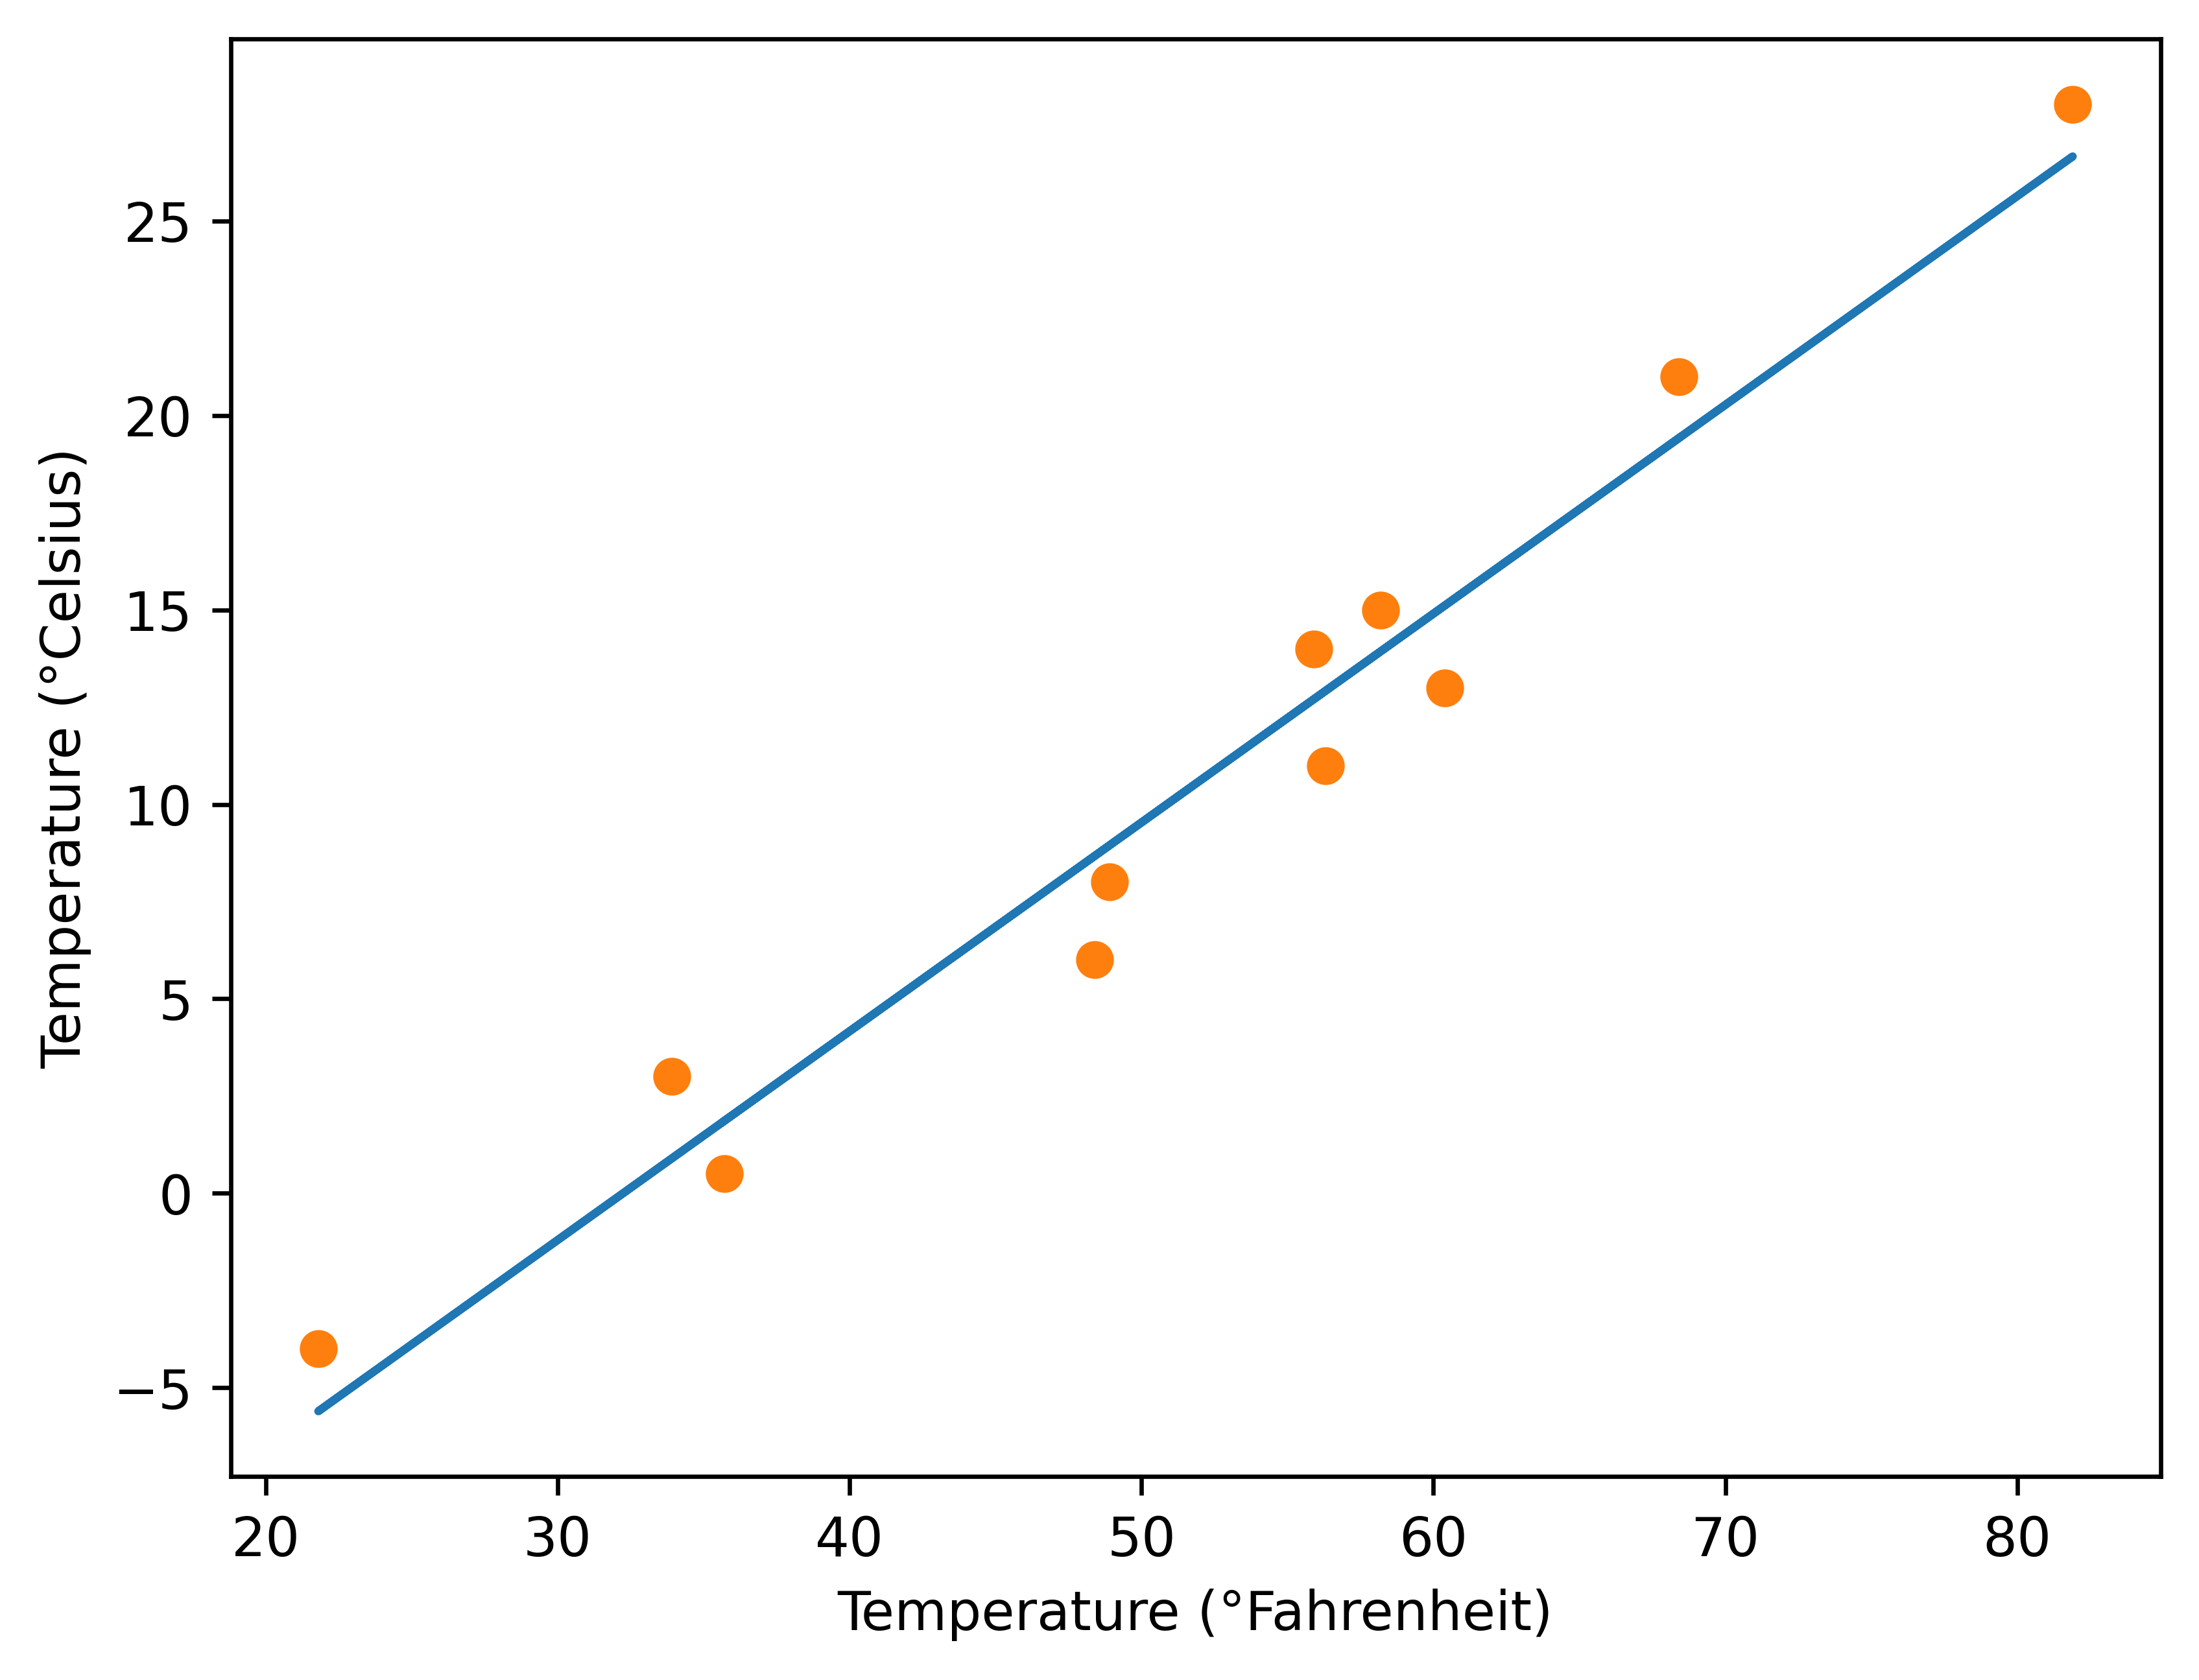

In [68]:
fig = plt.figure(dpi=600)
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

# 5.5 PyTorch’s autograd: Backpropagating all things

In our little adventure, we just saw a simple example of backpropagation: we com-
puted the gradient of a composition of functions—the model and the loss—with
respect to their innermost parameters (w and b) by propagating derivatives backward
using the chain rule. The basic requirement here is that all functions we’re dealing
with can be differentiated analytically. If this is the case, we can compute the gradi-
ent—what we earlier called “the rate of change of the loss”—with respect to the
parameters in one sweep.
Even if we have a complicated model with millions of parameters, as long as our
model is differentiable, computing the gradient of the loss with respect to the param-
eters amounts to writing the analytical expression for the derivatives and evaluating
them once. Granted, writing the analytical expression for the derivatives of a very deep
composition of linear and nonlinear functions is not a lot of fun.9 It isn’t particularly
quick, either.

In [69]:
def model(t_u, w, b):
    return w * t_u + b

In [70]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [71]:
params = torch.tensor([1.0, 0.0], requires_grad=True)

Notice the requires_grad=True argument to the tensor constructor? That argument
is telling PyTorch to track the entire family tree of tensors resulting from operations
on params. In other words, any tensor that will have params as an ancestor will have
access to the chain of functions that were called to get from params to that tensor. In
case these functions are differentiable (and most PyTorch tensor operations will be),
the value of the derivative will be automatically populated as a grad attribute of the
params tensor.
In general, all PyTorch tensors have an attribute named grad. Normally, it’s None:

In [72]:
params.grad is None

True

In [73]:
loss = loss_fn(model(t_u, *params), t_c)
loss.backward()
params.grad

tensor([4517.2969,   82.6000])

![Figure_5.10.png](Images_ch5/Figure_5.10.png)

We could have any number of tensors with requires_grad set to True and any compo-
sition of functions. In this case, PyTorch would compute the derivatives of the loss
throughout the chain of functions (the computation graph) and accumulate their val-
ues in the grad attribute of those tensors (the leaf nodes of the graph).
Alert! Big gotcha ahead. This is something PyTorch newcomers—and a lot of more
experienced folks, too—trip up on regularly. We just wrote <font color='red'>accumulate</font>, not <font color='red'>store</font>.

Let’s repeat together: calling backward will lead derivatives to accumulate at leaf nodes.
So if backward was called earlier, the loss is evaluated again, backward is called again
(as in any training loop), and the gradient at each leaf is accumulated (that is,
summed) on top of the one computed at the previous iteration, which leads to an
incorrect value for the gradient.
In order to prevent this from occurring, we need to zero the gradient explicitly at each
iteration. We can do this easily using the in-place zero_ method:

In [74]:
if params.grad is not None:
    params.grad.zero_()

In [75]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        if params.grad is not None:
            params.grad.zero_()
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        loss.backward()
        with torch.no_grad():
            params -= learning_rate * params.grad

        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
    return params

Note that our code updating params is not quite as straightforward as we might have
expected. There are two particularities. First, we are encapsulating the update in a
no_grad context using the Python with statement. This means within the with block,
the PyTorch autograd mechanism should look away:11 that is, not add edges to the for-
ward graph. In fact, when we are executing this bit of code, the forward graph that
PyTorch records is consumed when we call backward, leaving us with the params leaf
node. But now we want to change this leaf node before we start building a fresh for-
ward graph on top of it. While this use case is usually wrapped inside the optimizers
we discuss in section 5.5.2, we will take a closer look when we see another common use
of no_grad in section 5.5.4.
Second, we update params in place. This means we keep the same params tensor
around but subtract our update from it. When using autograd, we usually avoid in-
place updates because PyTorch’s autograd engine might need the values we would be
modifying for the backward pass. Here, however, we are operating without autograd,
and it is beneficial to keep the params tensor. Not replacing the parameters by assign-
ing new tensors to their variable name will become crucial when we register our
parameters with the optimizer in section 5.5.2.

In [76]:
training_loop(
n_epochs = 5000,
learning_rate = 1e-2,
params = torch.tensor([1.0, 0.0], requires_grad=True),
t_u = t_un,
t_c = t_c)

Epoch 500, Loss 7.860115
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

The result is the same as we got previously. Good for us! It means that while we are
capable of computing derivatives by hand, we no longer need to.

Optimizers a'la carte

The torch
module has an optim submodule where we can find classes implementing different
optimization algorithms.

In [77]:
import torch.optim as optim
dir(optim)

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'NAdam',
 'Optimizer',
 'RAdam',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional',
 '_multi_tensor',
 'lr_scheduler',
 'swa_utils']

![Figure_5.11.png](Images_ch5/Figure_5.11.png)

Each optimizer exposes two methods: zero_grad and step. zero_grad zeroes the
grad attribute of all the parameters passed to the optimizer upon construction. step
updates the value of those parameters according to the optimization strategy imple-
mented by the specific optimizer.

In [78]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-5
optimizer = optim.SGD([params], lr=learning_rate)

In [79]:
t_p = model(t_u, *params)
loss = loss_fn(t_p, t_c)
loss.backward()
optimizer.step()
params

tensor([ 9.5483e-01, -8.2600e-04], requires_grad=True)

In [80]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)
t_p = model(t_un, *params)
loss = loss_fn(t_p, t_c)
optimizer.zero_grad()
loss.backward()
optimizer.step()

In [81]:
params

tensor([1.7761, 0.1064], requires_grad=True)

In [82]:
def training_loop(n_epochs, optimizer, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
    return params

In [83]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)
training_loop(
n_epochs = 5000,
optimizer = optimizer,
params = params,
t_u = t_un,
t_c = t_c)

Epoch 500, Loss 7.860120
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

Again, we get the same result as before. Great: this is further confirmation that we
know how to descend a gradient by hand!

In order to test more optimizers, all we have to do is instantiate a different optimizer,
say Adam, instead of SGD. The rest of the code stays as it is. Pretty handy stuff.
We won’t go into much detail about Adam; suffice to say that it is a more sophisti-
cated optimizer in which the learning rate is set adaptively. In addition, it is a lot less
sensitive to the scaling of the parameters—so insensitive that we can go back to using the original (non-normalized) input t_u, and even increase the learning rate to 1e-1,
and Adam won’t even blink:

In [84]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-1
optimizer = optim.Adam([params], lr=learning_rate)
training_loop(
n_epochs = 2000,
optimizer = optimizer,
params = params,
t_u = t_u,
t_c = t_c)

Epoch 500, Loss 7.612900
Epoch 1000, Loss 3.086700
Epoch 1500, Loss 2.928579
Epoch 2000, Loss 2.927644


tensor([  0.5367, -17.3021], requires_grad=True)

The optimizer is not the only flexible part of our training loop. Let’s turn our atten-
tion to the model. In order to train a neural network on the same data and the same
loss, all we would need to change is the model function. It wouldn’t make particular
sense in this case, since we know that converting Celsius to Fahrenheit amounts to a
linear transformation, but we’ll do it anyway in chapter 6. We’ll see quite soon that
neural networks allow us to remove our arbitrary assumptions about the shape of the
function we should be approximating. Even so, we’ll see how neural networks manage
to be trained even when the underlying processes are highly nonlinear (such in the
case of describing an image with a sentence, as we saw in chapter 2).

[Splitting data] This is a vital thing to do, especially when the model we adopt could
potentially approximate functions of any shape, as in the case of neural networks. In
other words, a highly adaptable model will tend to use its many parameters to make
sure the loss is minimal at the data points, but we’ll have no guarantee that the model behaves well away from or in between the data points. After all, that’s what we’re asking
the optimizer to do: minimize the loss at the data points. Sure enough, if we had inde-
pendent data points that we didn’t use to evaluate our loss or descend along its nega-
tive gradient, we would soon find out that evaluating the loss at those independent
data points would yield higher-than-expected loss. We have already mentioned this
phenomenon, called overfitting.

The first action we can take to combat overfitting is recognizing that it might hap-
pen. In order to do so, as Kepler figured out in 1600, we must take a few data points
out of our dataset (the validation set) and only fit our model on the remaining data
points (the training set), as shown in figure 5.12. Then, while we’re fitting the model,
we can evaluate the loss once on the training set and once on the validation set. When
we’re trying to decide if we’ve done a good job of fitting our model to the data, we
must look at both!

![Figure_5.12.png](Images_ch5/Figure_5.12.png)

The training loss will tell us if our model can fit the training set at all—in other words,
if our model has enough capacity to process the relevant information in the data. If
our mysterious thermometer somehow managed to measure temperatures using a log-
arithmic scale, our poor linear model would not have had a chance to fit those mea-
surements and provide us with a sensible conversion to Celsius. In that case, our
training loss (the loss we were printing in the training loop) would stop decreasing
well before approaching zero.

So, <font color='red'>rule 1</font>: if the training loss is not decreasing, chances are the
model is too simple for the data. The other possibility is that our data just doesn’t con-
tain meaningful information that lets it explain the output: if the nice folks at the shop
sell us a barometer instead of a thermometer, we will have little chance of predicting
temperature in Celsius from just pressure,

What about the validation set? Well, if the loss evaluated in the validation set doesn’t
decrease along with the training set, it means our model is improving its fit of the sam-
ples it is seeing during training, but it is not generalizing to samples outside this precise
set. As soon as we evaluate the model at new, previously unseen points, the values of
the loss function are poor.

So, <font color='red'>rule 2</font>: if the training loss and the validation loss
diverge, we’re overfitting.

![Figure_5.13.png](Images_ch5/Figure_5.13.png)

What’s the cure, though? Good question. From what we just said, overfitting really
looks like a problem of making sure the behavior of the model in between data points
is sensible for the process we’re trying to approximate. First of all, we should make
sure we get enough data for the process. If we collected data from a sinusoidal pro-
cess by sampling it regularly at a low frequency, we would have a hard time fitting a
model to it.
Assuming we have enough data points, we should make sure the model that is
capable of fitting the training data is as regular as possible in between them. There are
several ways to achieve this. One is adding penalization terms to the loss function, to
make it cheaper for the model to behave more smoothly and change more slowly (up
to a point). Another is to add noise to the input samples, to artificially create new data
points in between training data samples and force the model to try to fit those, too.
There are several other ways, all of them somewhat related to these. But the best favor
we can do to ourselves, at least as a first move, is to make our model simpler. From an
intuitive standpoint, a simpler model may not fit the training data as perfectly as a
more complicated model would, but it will likely behave more regularly in between
data points.
We’ve got some nice trade-offs here. On the one hand, we need the model to have
enough capacity for it to fit the training set. On the other, we need the model to avoid
overfitting. Therefore, in order to choose the right size for a neural network model in
terms of parameters, the process is based on two steps: increase the size until it fits,
and then scale it down until it stops overfitting.

In [85]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)
shuffled_indices = torch.randperm(n_samples)
train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]
train_indices, val_indices

(tensor([1, 2, 0, 4, 8, 9, 7, 3, 5]), tensor([ 6, 10]))

In [86]:
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]
val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]
train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u

In [94]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u,
train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)
        
        val_t_p = model(val_t_u, *params)
        val_loss = loss_fn(val_t_p, val_t_c)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        if epoch <= 3 or epoch % 500 == 0:
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
            f" Validation loss {val_loss.item():.4f}")
    return params

In [95]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)
training_loop(
n_epochs = 3000,
optimizer = optimizer,
params = params,
train_t_u = train_t_un,
val_t_u = val_t_un,
train_t_c = train_t_c,
val_t_c = val_t_c)

Epoch 1, Training loss 75.9278, Validation loss 100.3288
Epoch 2, Training loss 37.4690, Validation loss 45.1741
Epoch 3, Training loss 31.4738, Validation loss 32.5256
Epoch 500, Training loss 8.0829, Validation loss 6.6445
Epoch 1000, Training loss 3.6888, Validation loss 4.2357
Epoch 1500, Training loss 2.8342, Validation loss 4.4852
Epoch 2000, Training loss 2.6680, Validation loss 4.8504
Epoch 2500, Training loss 2.6356, Validation loss 5.0611
Epoch 3000, Training loss 2.6293, Validation loss 5.1637


tensor([  5.3972, -17.8577], requires_grad=True)

Here we are not being entirely fair to our model. The validation set is really small, so
the validation loss will only be meaningful up to a point. In any case, we note that the
validation loss is higher than our training loss, although not by an order of magni-
tude. We expect a model to perform better on the training set, since the model
parameters are being shaped by the training set. Our main goal is to also see both the
training loss and the validation loss decreasing. While ideally both losses would be
roughly the same value, as long as the validation loss stays reasonably close to the
training loss, we know that our model is continuing to learn generalized things about
our data. In figure 5.14, case C is ideal, while D is acceptable. In case A, the model
isn’t learning at all; and in case B, we see overfitting. We’ll see more meaningful exam-
ples of overfitting in chapter 12.

![Figure_5.14.png](Images_ch5/Figure_5.14.png)

From the previous training loop, we can appreciate that we only ever call backward on
train_loss. Therefore, errors will only ever backpropagate based on the training
set—the validation set is used to provide an independent evaluation of the accuracy of
the model’s output on data that wasn’t used for training.
The curious reader will have an embryo of a question at this point. The model is
evaluated twice—once on train_t_u and once on val_t_u—and then backward is
called. Won’t this confuse autograd? Won’t backward be influenced by the values gen-
erated during the pass on the validation set?
Luckily for us, this isn’t the case. The first line in the training loop evaluates model
on train_t_u to produce train_t_p. Then train_loss is evaluated from train_t_p.
This creates a computation graph that links train_t_u to train_t_p to train_loss.
When model is evaluated again on val_t_u, it produces val_t_p and val_loss. In this
case, a separate computation graph will be created that links val_t_u to val_t_p to
val_loss. Separate tensors have been run through the same functions, model and
loss_fn, generating separate computation graphs, as shown in figure 5.15.

![Figure_5.15.png](Images_ch5/Figure_5.15.png)

# Summary

* Linear models are the simplest reasonable model to use to fit data.
* Convex optimization techniques can be used for linear models, but they do not generalize to neural networks, so we focus on stochastic gradient descent for parameter estimation.
* Deep learning can be used for generic models that are not engineered for solv-
ing a specific task, but instead can be automatically adapted to specialize them-
selves on the problem at hand.
* Learning algorithms amount to optimizing parameters of models based on
observations. A loss function is a measure of the error in carrying out a task,
such as the error between predicted outputs and measured values. The goal is
to get the loss function as low as possible.
* The rate of change of the loss function with respect to the model parameters
can be used to update the same parameters in the direction of decreasing loss.
* The optim module in PyTorch provides a collection of ready-to-use optimizers
for updating parameters and minimizing loss functions.
* Optimizers use the autograd feature of PyTorch to compute the gradient for
each parameter, depending on how that parameter contributes to the final out-
put. This allows users to rely on the dynamic computation graph during com-
plex forward passes.
* Context managers like with torch.no_grad(): can be used to control auto-
grad’s behavior.
* Data is often split into separate sets of training samples and validation samples.
This lets us evaluate a model on data it was not trained on.
* Overfitting a model happens when the model’s performance continues to
improve on the training set but degrades on the validation set. This is usually
due to the model not generalizing, and instead memorizing the desired outputs
for the training set.